In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,MinMaxScaler
import xgboost as xgb
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [50]:
Dataset_dir = ["./train.csv", "./store.csv","./test.csv"]
pd.options.display.max_columns = None

In [51]:
def load_data(dir):
    data = pd.read_csv(dir[0],parse_dates=[2])
    store = pd.read_csv(dir[1])
    test = pd.read_csv(dir[2],parse_dates=[3])
    return data,store,test

In [52]:
train,store,test = load_data(Dataset_dir)
train = train[train['Open'] != 0]
train = pd.merge(train, store, on='Store')
test = pd.merge(test, store, on='Store')
print(train.columns)
print(test.columns)

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')
Index(['Id', 'Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')


In [53]:
#对时间序列进行分析
#总的销售趋势2013-2015年
# train['date'] = pd.to_datetime(train.Date)
# data = train.loc[:,['Sales']]
# data = data.set_index(train.date)
# data.plot()

# weekly = data.resample('W').sum()
# weekly.plot()

# dayily = data.resample('D').sum()
# dayily.plot()

In [54]:
TESTID = test['Id']

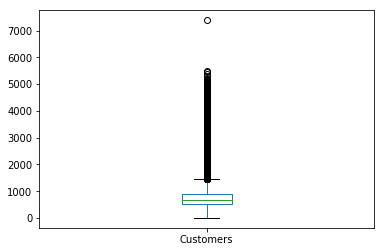

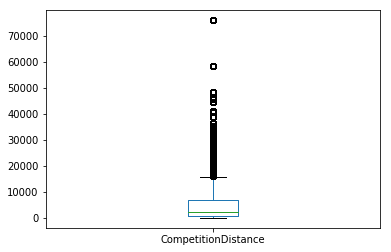

In [55]:
train.Customers.plot(kind='box')
plt.show()
train.CompetitionDistance.plot(kind='box')
plt.show()

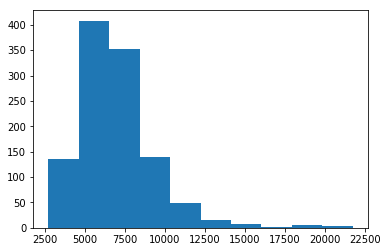

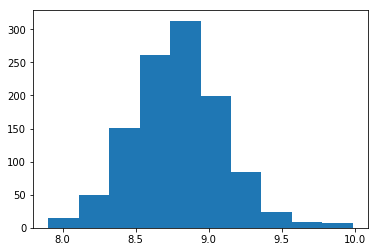

In [56]:
sales_mean = train.groupby('Store')['Sales'].mean()
plt.hist(sales_mean)
plt.show()
plt.hist(np.log1p(sales_mean))
plt.show()

In [57]:
Store_DaysWeek = train.groupby(['Store','DayOfWeek'])
sw_mean = Store_DaysWeek["Sales"].mean()

In [58]:
def build_feature(data,istrain):
    mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
    data.StoreType.replace(mappings, inplace=True)
    data.Assortment.replace(mappings, inplace=True)
    data.StateHoliday.replace(mappings, inplace=True)
    
    #CART回归树不需要预处理数据和NAn值
#     distance_max = max(data.CompetitionDistance)
#     data.CompetitionDistance.mask(data.CompetitionDistance.isna(),other=distance_max,inplace=True)
#     print(data.CompetitionDistance.isnull().any())
#     min_max_scaler = MinMaxScaler()
#     scaledata = min_max_scaler.fit_transform(data[['CompetitionDistance']])
#     data.drop("CompetitionDistance",axis=1)
#     data['CompetitionDistance'] = scaledata
    #时间序列问题 需要考虑进时间的因素
    data['Year'] = data.Date.dt.year
    print(data['Year'].dtype)
    data['Month'] = data.Date.dt.month
    data['Day'] = data.Date.dt.day
    
    if istrain:
        data.drop(['Store','Open','Date','Customers','PromoInterval',],axis=1,inplace=True)
        #data.drop(['Store','Open','Date','Customers','PromoInterval','SchoolHoliday','Promo2','StateHoliday','Promo2SinceWeek'],axis=1,inplace=True)
    else:
        data.drop(['Id','Store','Open','Date','PromoInterval',],axis=1,inplace=True)
        #data.drop(['Id','Store','Open','Date','PromoInterval','SchoolHoliday','Promo2','StateHoliday','Promo2SinceWeek'],axis=1,inplace=True)
    print(data.columns)

In [59]:
#build train data
build_feature(train,True)
#build test data
build_feature(test,False)

int64
Index(['DayOfWeek', 'Sales', 'Promo', 'StateHoliday', 'SchoolHoliday',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'Year', 'Month', 'Day'],
      dtype='object')
int64
Index(['DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType',
       'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'Year', 'Month', 'Day'],
      dtype='object')


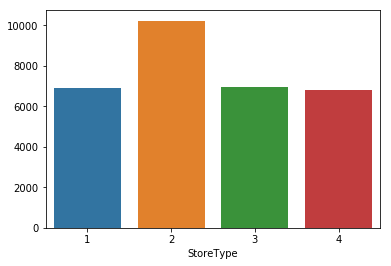

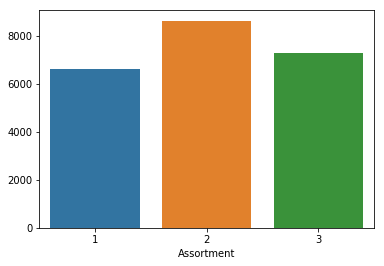

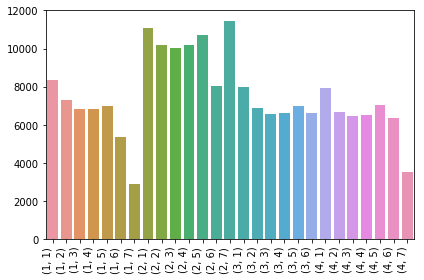

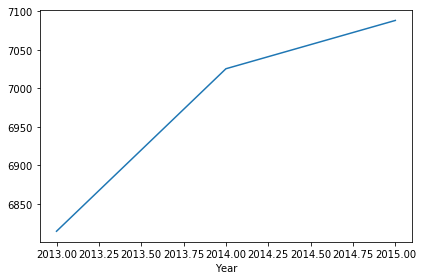

In [60]:
ST_gp = train.groupby('StoreType')['Sales'].agg('mean')
import seaborn as sns
sns.barplot(ST_gp.index,ST_gp.values)
plt.show()

As_gp = train.groupby('Assortment')['Sales'].agg('mean')
sns.barplot(As_gp.index,As_gp.values)
plt.show()
Dayweek_gp = train.groupby(['StoreType','DayOfWeek'])['Sales'].agg('mean')
ax = sns.barplot(Dayweek_gp.index,Dayweek_gp.values)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
plt.tight_layout()
plt.show()

#每年销售额的趋势
YearS_gp = train.groupby(['Year'])['Sales'].agg("mean")
ax2 = sns.lineplot(YearS_gp.index,YearS_gp.values)
plt.tight_layout()
plt.show()

In [61]:
#split train vaild data
from sklearn.model_selection import train_test_split
X_train, X_valid = train_test_split(train, test_size=0.012, random_state=10)
print(X_train.shape)
print(X_valid.shape)
Y_train = X_train["Sales"]
Y_valid = X_valid["Sales"]
X_train.drop("Sales",axis=1,inplace=True)
X_valid.drop("Sales",axis=1,inplace=True)

(834259, 16)
(10133, 16)


/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


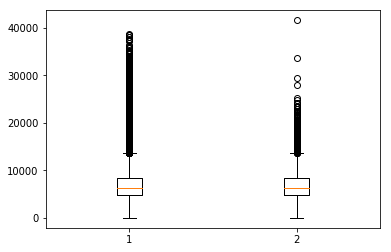

In [62]:
plt.boxplot([Y_train,Y_valid])
plt.show()

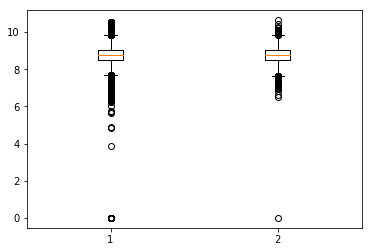

In [63]:
Y_train = np.log1p(Y_train)
Y_valid = np.log1p(Y_valid)
plt.boxplot([Y_train,Y_valid])
plt.show()

In [64]:
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w

def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe

def rmspe_xg(yhat, y):
    # y = y.values
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe

In [66]:
params = {"objective": "reg:linear",
          "eta": 0.1,
          "max_depth": 12,
          "min_child_weight":1,
          "gamma" :0,
          "subsample": 0.7,
          "colsample_bytree": 0.7,
          "silent": 1
          }
num_trees = 300

dtrain = xgb.DMatrix(X_train, Y_train)
dvalid = xgb.DMatrix(X_valid, Y_valid)
dtest = xgb.DMatrix(test)
watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
ret = {}
import time
start = time.time()
gbm = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=50,evals_result =ret, feval=rmspe_xg, verbose_eval=True)
end = time.time()
print("Train use time:",end-start)

[0]	eval-rmse:7.43899	train-rmse:7.44358	eval-rmspe:0.999474	train-rmspe:0.999494
Multiple eval metrics have been passed: 'train-rmspe' will be used for early stopping.

Will train until train-rmspe hasn't improved in 50 rounds.
[1]	eval-rmse:6.69698	train-rmse:6.70133	eval-rmspe:0.998764	train-rmspe:0.998787
[2]	eval-rmse:6.02906	train-rmse:6.03313	eval-rmspe:0.997486	train-rmspe:0.997514
[3]	eval-rmse:5.42804	train-rmse:5.43176	eval-rmspe:0.995341	train-rmspe:0.995374
[4]	eval-rmse:4.88742	train-rmse:4.89086	eval-rmspe:0.991941	train-rmspe:0.991983
[5]	eval-rmse:4.40084	train-rmse:4.40383	eval-rmspe:0.986886	train-rmspe:0.986934
[6]	eval-rmse:3.96318	train-rmse:3.96587	eval-rmspe:0.97969	train-rmspe:0.979745
[7]	eval-rmse:3.56962	train-rmse:3.572	eval-rmspe:0.969894	train-rmspe:0.969961
[8]	eval-rmse:3.21531	train-rmse:3.21778	eval-rmspe:0.957116	train-rmspe:0.957216
[9]	eval-rmse:2.89711	train-rmse:2.89925	eval-rmspe:0.941072	train-rmspe:0.941196
[10]	eval-rmse:2.61006	train-rmse:2.

[96]	eval-rmse:0.157418	train-rmse:0.142517	eval-rmspe:0.14182	train-rmspe:0.176557
[97]	eval-rmse:0.157105	train-rmse:0.142131	eval-rmspe:0.141521	train-rmspe:0.176364
[98]	eval-rmse:0.156974	train-rmse:0.141862	eval-rmspe:0.14134	train-rmspe:0.176399
[99]	eval-rmse:0.156741	train-rmse:0.141576	eval-rmspe:0.141167	train-rmspe:0.176178
[100]	eval-rmse:0.156364	train-rmse:0.141102	eval-rmspe:0.140667	train-rmspe:0.17595
[101]	eval-rmse:0.155617	train-rmse:0.140196	eval-rmspe:0.139744	train-rmspe:0.175179
[102]	eval-rmse:0.15499	train-rmse:0.139453	eval-rmspe:0.138968	train-rmspe:0.174633
[103]	eval-rmse:0.154694	train-rmse:0.139046	eval-rmspe:0.13861	train-rmspe:0.174217
[104]	eval-rmse:0.153965	train-rmse:0.138072	eval-rmspe:0.13773	train-rmspe:0.173498
[105]	eval-rmse:0.153306	train-rmse:0.137331	eval-rmspe:0.136945	train-rmspe:0.172598
[106]	eval-rmse:0.152644	train-rmse:0.13654	eval-rmspe:0.13616	train-rmspe:0.171913
[107]	eval-rmse:0.15256	train-rmse:0.136387	eval-rmspe:0.136072	tr

[192]	eval-rmse:0.136918	train-rmse:0.111369	eval-rmspe:0.117341	train-rmspe:0.14281
[193]	eval-rmse:0.136869	train-rmse:0.111242	eval-rmspe:0.117283	train-rmspe:0.142681
[194]	eval-rmse:0.136828	train-rmse:0.111104	eval-rmspe:0.117225	train-rmspe:0.14248
[195]	eval-rmse:0.136736	train-rmse:0.110921	eval-rmspe:0.117112	train-rmspe:0.142192
[196]	eval-rmse:0.13665	train-rmse:0.110807	eval-rmspe:0.117024	train-rmspe:0.142063
[197]	eval-rmse:0.136562	train-rmse:0.110612	eval-rmspe:0.116903	train-rmspe:0.141494
[198]	eval-rmse:0.136465	train-rmse:0.11045	eval-rmspe:0.11681	train-rmspe:0.141352
[199]	eval-rmse:0.136411	train-rmse:0.110294	eval-rmspe:0.116729	train-rmspe:0.141215
[200]	eval-rmse:0.136247	train-rmse:0.110015	eval-rmspe:0.116506	train-rmspe:0.140842
[201]	eval-rmse:0.136207	train-rmse:0.109956	eval-rmspe:0.11645	train-rmspe:0.140781
[202]	eval-rmse:0.136195	train-rmse:0.109827	eval-rmspe:0.116559	train-rmspe:0.14059
[203]	eval-rmse:0.136036	train-rmse:0.109504	eval-rmspe:0.116

[288]	eval-rmse:0.131508	train-rmse:0.096789	eval-rmspe:0.110224	train-rmspe:0.121042
[289]	eval-rmse:0.131442	train-rmse:0.096675	eval-rmspe:0.110156	train-rmspe:0.120894
[290]	eval-rmse:0.131392	train-rmse:0.096564	eval-rmspe:0.110083	train-rmspe:0.120829
[291]	eval-rmse:0.131322	train-rmse:0.096467	eval-rmspe:0.109986	train-rmspe:0.12071
[292]	eval-rmse:0.131314	train-rmse:0.096425	eval-rmspe:0.109981	train-rmspe:0.120038
[293]	eval-rmse:0.131345	train-rmse:0.096276	eval-rmspe:0.110032	train-rmspe:0.119898
[294]	eval-rmse:0.131245	train-rmse:0.096039	eval-rmspe:0.109885	train-rmspe:0.119596
[295]	eval-rmse:0.131321	train-rmse:0.095971	eval-rmspe:0.11001	train-rmspe:0.119755
[296]	eval-rmse:0.131286	train-rmse:0.095815	eval-rmspe:0.109983	train-rmspe:0.11907
[297]	eval-rmse:0.131311	train-rmse:0.095698	eval-rmspe:0.10995	train-rmspe:0.118977
[298]	eval-rmse:0.13126	train-rmse:0.09561	eval-rmspe:0.10989	train-rmspe:0.118847
[299]	eval-rmse:0.131227	train-rmse:0.095545	eval-rmspe:0.109

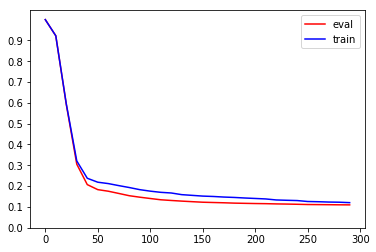

In [69]:
evaldata = ret['eval']['rmspe'][0:num_trees:10]
traindata = ret['train']['rmspe'][0:num_trees:10]
plt.plot(range(0,num_trees,10),evaldata,color='red',label="eval")
plt.plot(range(0,num_trees,10),traindata,color='blue',label="train")
plt.legend(loc='best')
y_tick = np.arange(0,1,0.1)
plt.yticks(y_tick)
plt.show()

In [70]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
param_test1 = {
 'max_depth':range(10,13,1),
 'min_child_weight':range(4,6,2)
}
gsearch1 = GridSearchCV(estimator = xgb.XGBRegressor(max_depth=5,learning_rate =0.1, n_estimators=num_trees,min_child_weight=1, gamma=0,verbose = 10,subsample=0.8,colsample_bytree=0.8,nthread=4,scale_pos_weight=1),
                        param_grid = param_test1,scoring ='neg_mean_squared_error',cv=5)
gsearch1.fit(X_train, Y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=300,
       n_jobs=1, nthread=4, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8, verbose=10),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': range(10, 13), 'min_child_weight': range(4, 6, 2)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [71]:
print(gsearch1.best_params_)

{'max_depth': 12, 'min_child_weight': 4}


In [26]:
param_test2 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch2 = GridSearchCV(estimator = xgb.XGBRegressor(max_depth=9,learning_rate =0.1, n_estimators=36,min_child_weight=3, gamma=0,verbose = 10,subsample=0.8,colsample_bytree=0.8,nthread=4,scale_pos_weight=1),
                        param_grid = param_test2,scoring ='neg_mean_squared_error',cv=5)

gsearch2.fit(X_train, Y_train)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=9, min_child_weight=3, missing=None, n_estimators=36,
       n_jobs=1, nthread=4, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8, verbose=10),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [27]:
print(gsearch2.best_params_)

{'gamma': 0.1}


In [73]:
params2 = {"objective": "reg:linear",
          "eta": 0.2,
          "max_depth": 12,
          "min_child_weight":4,
          "gamma" :0.1,
          "subsample": 0.7,
          "colsample_bytree": 0.7,
          "silent": 1
          }

start = time.time()
gbm2 = xgb.train(params2, dtrain, 300, evals=watchlist, early_stopping_rounds=50,evals_result =ret, feval=rmspe_xg, verbose_eval=True)
end = time.time()

[0]	eval-rmse:6.61459	train-rmse:6.61894	eval-rmspe:0.998646	train-rmspe:0.998669
Multiple eval metrics have been passed: 'train-rmspe' will be used for early stopping.

Will train until train-rmspe hasn't improved in 50 rounds.
[1]	eval-rmse:5.29584	train-rmse:5.29992	eval-rmspe:0.994636	train-rmspe:0.994675
[2]	eval-rmse:4.24143	train-rmse:4.24475	eval-rmspe:0.984512	train-rmspe:0.984574
[3]	eval-rmse:3.39884	train-rmse:3.40132	eval-rmspe:0.96411	train-rmspe:0.964207
[4]	eval-rmse:2.72533	train-rmse:2.72748	eval-rmspe:0.929864	train-rmspe:0.930031
[5]	eval-rmse:2.18715	train-rmse:2.18856	eval-rmspe:0.880713	train-rmspe:0.880935
[6]	eval-rmse:1.75839	train-rmse:1.75941	eval-rmspe:0.817425	train-rmspe:0.817879
[7]	eval-rmse:1.41743	train-rmse:1.41803	eval-rmspe:0.743716	train-rmspe:0.744687
[8]	eval-rmse:1.1459	train-rmse:1.1466	eval-rmspe:0.664653	train-rmspe:0.666665
[9]	eval-rmse:0.931714	train-rmse:0.932273	eval-rmspe:0.585377	train-rmspe:0.589114
[10]	eval-rmse:0.756586	train-rmse

[96]	eval-rmse:0.138973	train-rmse:0.119073	eval-rmspe:0.120678	train-rmspe:0.163384
[97]	eval-rmse:0.13894	train-rmse:0.118893	eval-rmspe:0.120613	train-rmspe:0.163226
[98]	eval-rmse:0.138951	train-rmse:0.118786	eval-rmspe:0.120606	train-rmspe:0.163189
[99]	eval-rmse:0.138824	train-rmse:0.118624	eval-rmspe:0.120402	train-rmspe:0.163015
[100]	eval-rmse:0.138793	train-rmse:0.118578	eval-rmspe:0.120377	train-rmspe:0.163249
[101]	eval-rmse:0.138611	train-rmse:0.118318	eval-rmspe:0.120166	train-rmspe:0.162939
[102]	eval-rmse:0.138572	train-rmse:0.118088	eval-rmspe:0.120133	train-rmspe:0.162868
[103]	eval-rmse:0.138488	train-rmse:0.117889	eval-rmspe:0.120042	train-rmspe:0.162703
[104]	eval-rmse:0.138099	train-rmse:0.117389	eval-rmspe:0.11954	train-rmspe:0.162056
[105]	eval-rmse:0.137963	train-rmse:0.11713	eval-rmspe:0.119516	train-rmspe:0.161778
[106]	eval-rmse:0.137835	train-rmse:0.116971	eval-rmspe:0.119292	train-rmspe:0.159993
[107]	eval-rmse:0.137734	train-rmse:0.11683	eval-rmspe:0.1192

[192]	eval-rmse:0.135173	train-rmse:0.106415	eval-rmspe:0.115288	train-rmspe:0.139224
[193]	eval-rmse:0.135154	train-rmse:0.106376	eval-rmspe:0.115269	train-rmspe:0.13919
[194]	eval-rmse:0.135199	train-rmse:0.106334	eval-rmspe:0.11531	train-rmspe:0.139096
[195]	eval-rmse:0.13519	train-rmse:0.106204	eval-rmspe:0.115289	train-rmspe:0.138995
[196]	eval-rmse:0.13518	train-rmse:0.106161	eval-rmspe:0.11532	train-rmspe:0.138973
[197]	eval-rmse:0.135215	train-rmse:0.106067	eval-rmspe:0.115315	train-rmspe:0.138863
[198]	eval-rmse:0.135236	train-rmse:0.105979	eval-rmspe:0.115259	train-rmspe:0.138828
[199]	eval-rmse:0.135158	train-rmse:0.105902	eval-rmspe:0.115175	train-rmspe:0.138672
[200]	eval-rmse:0.135142	train-rmse:0.105749	eval-rmspe:0.115118	train-rmspe:0.138476
[201]	eval-rmse:0.135125	train-rmse:0.105727	eval-rmspe:0.115094	train-rmspe:0.138458
[202]	eval-rmse:0.135147	train-rmse:0.105644	eval-rmspe:0.115	train-rmspe:0.136487
[203]	eval-rmse:0.13521	train-rmse:0.105466	eval-rmspe:0.11513

[288]	eval-rmse:0.134483	train-rmse:0.100809	eval-rmspe:0.113863	train-rmspe:0.119834
[289]	eval-rmse:0.134439	train-rmse:0.100769	eval-rmspe:0.113919	train-rmspe:0.119824
[290]	eval-rmse:0.134457	train-rmse:0.100701	eval-rmspe:0.113937	train-rmspe:0.118022
[291]	eval-rmse:0.134466	train-rmse:0.100681	eval-rmspe:0.113932	train-rmspe:0.118017
[292]	eval-rmse:0.134534	train-rmse:0.100664	eval-rmspe:0.113923	train-rmspe:0.118024
[293]	eval-rmse:0.134551	train-rmse:0.100593	eval-rmspe:0.113928	train-rmspe:0.117536
[294]	eval-rmse:0.134557	train-rmse:0.100542	eval-rmspe:0.113933	train-rmspe:0.117418
[295]	eval-rmse:0.134564	train-rmse:0.100514	eval-rmspe:0.113984	train-rmspe:0.117758
[296]	eval-rmse:0.134566	train-rmse:0.10048	eval-rmspe:0.113986	train-rmspe:0.117724
[297]	eval-rmse:0.134556	train-rmse:0.100438	eval-rmspe:0.113956	train-rmspe:0.11769
[298]	eval-rmse:0.134565	train-rmse:0.100426	eval-rmspe:0.113962	train-rmspe:0.117684
[299]	eval-rmse:0.134562	train-rmse:0.100412	eval-rmspe:

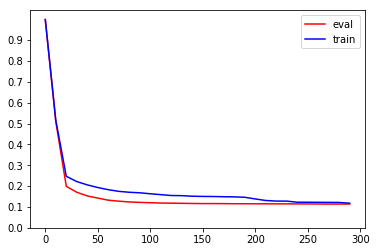

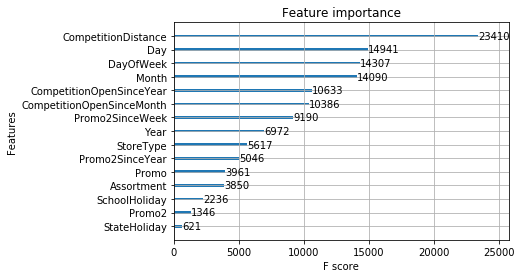

In [74]:
#从最终的训练importnace中看果然是时间序列影响比较大
evaldata = ret['eval']['rmspe'][0:num_trees:10]
traindata = ret['train']['rmspe'][0:num_trees:10]
plt.plot(range(0,num_trees,10),evaldata,color='red',label="eval")
plt.plot(range(0,num_trees,10),traindata,color='blue',label="train")
plt.legend(loc='best')
y_tick = np.arange(0,1,0.1)
plt.yticks(y_tick)
plt.show()
xgb.plot_importance(gbm2)

In [75]:
#预测测试数据
regetTest = pd.read_csv("./test.csv")
replaceID = regetTest[regetTest.Open == 0.0]['Id']
print(replaceID.values)
test_probs = gbm2.predict(dtest)
result = pd.DataFrame({"Id": TESTID , 'Sales': np.exp(test_probs)})
result.loc[result['Id'].isin(replaceID.values),'Sales'] = 0

[  544   677   841 ... 40230 40231 40232]


In [76]:
#预测测试数据输出
result.to_csv("xgboost_submission.csv", index=False)